# Exploratory code

The software in this file represents some of our explorations and experiments that were used to make our final analysis.

## Parsing the schema file

In [1]:
from schema import Schema
from tabulate import tabulate
from importlib import reload

In [2]:
schema = Schema("../data/schema.csv")
print(schema)


#########################################################################
job_events (job_events/part-?????-of-?????.csv.gz):
  field number  content           format       mandatory    formatter
--------------  ----------------  -----------  -----------  ----------------------------------------------------------------
             0  time              INTEGER      True         <function parse_schema_line.<locals>.<lambda> at 0x7f24d907b370>
             1  missing info      INTEGER      False        <function parse_schema_line.<locals>.<lambda> at 0x7f24d907ac20>
             2  job ID            INTEGER      True         <function parse_schema_line.<locals>.<lambda> at 0x7f24d907aef0>
             3  event type        INTEGER      True         <function parse_schema_line.<locals>.<lambda> at 0x7f24d912fac0>
             4  user              STRING_HASH  False        <function parse_schema_line.<locals>.<lambda> at 0x7f24d907b400>
             5  scheduling class  INTEGER      False 

## Starting Spark

In [3]:
from pyspark import SparkContext

# start spark with 1 worker thread
sc = SparkContext("local[*]")
sc.setLogLevel("ERROR")

22/12/13 17:22:14 WARN Utils: Your hostname, Kixus-k resolves to a loopback address: 127.0.1.1; using 130.190.51.188 instead (on interface wlp4s0)
22/12/13 17:22:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/13 17:22:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Analysis on machine events

This file describes events that occurred to the machines in the cluster, as well as their specifications (initial events).

First, let us see the schema of this file's data:

In [4]:
print(tabulate(schema.get_table_schema('machine_events')['fields'],headers='keys'))

  field number  content      format       mandatory    formatter
--------------  -----------  -----------  -----------  ----------------------------------------------------------------
             0  time         INTEGER      True         <function parse_schema_line.<locals>.<lambda> at 0x7f24b7f0c1f0>
             1  machine ID   INTEGER      True         <function parse_schema_line.<locals>.<lambda> at 0x7f24b7f0c4c0>
             2  event type   INTEGER      True         <function parse_schema_line.<locals>.<lambda> at 0x7f24b7f0c430>
             3  platform ID  STRING_HASH  False        <function parse_schema_line.<locals>.<lambda> at 0x7f24b7f0c700>
             4  CPUs         FLOAT        False        <function parse_schema_line.<locals>.<lambda> at 0x7f24b7f0c5e0>
             5  Memory       FLOAT        False        <function parse_schema_line.<locals>.<lambda> at 0x7f24b7f0c790>


### Machine Event RDD

In [5]:
machine_events_get = schema.field_getters('machine_events')
machine_events = schema.load_rdd(sc,'machine_events')
machine_events.cache()

for elem in machine_events.take(5):
	print(elem)

### Distribution of CPU usage (Q1)

For the following, we only account for the machine creation events. We note that this method could count a given machine more than once, should it happen to be added more than once (and removed in-between) or modified.

Distribution of machine capacity based on their CPU power:

In [ ]:
from operator import add

cpu = machine_events_get['CPUs']
event = machine_events_get['event type']
machine_id = machine_events_get['machine ID']
time = machine_events_get['time']

cpu_usage = machine_events \
    .filter(lambda row: event(row) == 0 and cpu(row) is not None) \
    .map(lambda row: (machine_id(row),row)) \
    .reduceByKey(lambda r1,r2: r1 if time(r1)>time(r2) else r2) \
    .map(lambda row: (cpu(row[1]), 1)) \
    .reduceByKey(add) \
    .sortBy(lambda x: x[0])

for usage,nb in cpu_usage.collect():
    print(f"{nb} machines have CPU {usage}")


In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
legend = cpu_usage.map(lambda x: str(x[0]) if x[0] is not None else 'None').collect()
count = cpu_usage.sortByKey().map(lambda x: x[1]).collect()
ax.bar(legend,count)
plt.show()

### Lost Computational Power

In [ ]:
machines_history = machine_events \
    .map(lambda row: (machine_id(row),row)) \
    .aggregateByKey(None,lambda acc, e: acc+[e] if acc is not None else [e],add) \
    .map(lambda machine: machine[1]) \

for e in machines_history.take(10):
    print(tabulate(e))

In [ ]:
machines_history.filter(lambda m: sorted(m)).count() - machines_history.count()

The trace period starts at 600 seconds (aka $6 \times 10^{8}$ microseconds), to obtain the total trace time, we find the latest event time and subtracted $6 \times 10^{8}$ to it.

In [ ]:
from math import ceil

total_trace_time = time(machine_events.max(lambda row: time(row))) - 6*10**8

print(f'The total trace time is {total_trace_time} µs ≈ {ceil(total_trace_time/(10**6 * 3600))} hours ≈ {ceil(total_trace_time/(10**6 * 3600 * 24))} days')

Once we have this number, computing the total computation power of a given machine is a matter of subtracting the starting time of the machine and multiplying by the CPU capacity. We assume here that the CPU capacity of a machine never changes, and we remove the machines that have some cpu values at None to prevent weird events.

In [ ]:
def lost_and_total_power(events):
    # Functions and Variables
    status = machine_events_get['event type']
    time = machine_events_get['time']
    start = time(events[0])
    cpu = machine_events_get['CPUs'](events[0])

    # Lost time
    lost_time = 0
    for i,m in enumerate(events):
        if i==0:
            continue
        if status(m)==0 and status(events[i-1])==1:
            lost_time += time(m) - time(events[i-1])
        
    # Total time
    total_time = total_trace_time if (start < 6*10**8) else (total_trace_time - start + 6*10**8)

    # Resulting power
    return (lost_time*cpu,total_time*cpu)

def has_none_cpu(events):
    cpu = machine_events_get['CPUs']
    for m in events:
        if cpu(m) is None:
            return True
    return False

print(f'There are {machines_history.filter(has_none_cpu).count()} machines with None values in their CPUs. They will not be evaluated.')

power_lost_and_total = machines_history \
    .filter(lambda m: not has_none_cpu(m)) \
    .map(lost_and_total_power) \
    .reduce(lambda p1,p2: (p1[0]+p2[0],p1[1]+p2[1]))

print(f'During the trace time, around {(power_lost_and_total[0]/power_lost_and_total[1])*100:.4f}% of the computational power was lost.\
\nThe exact percentage obtained is {(power_lost_and_total[0]/power_lost_and_total[1])*100}% !')


## Distribution of jobs and tasks per scheduling class

We will evaluate the distribution over **submitted** tasks and jobs. It also implies that we do not consider the distribution _over time_ but only within the _set_ of all submitted tasks and jobs.

We could also consider the evolution of the scheduling class through time, looking at the event types UPDATE_PENDING and UPDATE_RUNNING. This is a different perspective where time is a key component.

### Studying jobs

We start our analysis with jobs. They should be fewer, as there can be many tasks per job, but one job per task.

Before all, the schema for the tables we will use:

In [ ]:
print(tabulate(schema.get_table_schema('job_events')['fields'], headers='keys', maxcolwidths=40))

First step, gather the events based on the task or job they refer to. We expect such lists of events to be small enough to be handled in regular python lists.

In [ ]:
job_events = schema.load_rdd(sc,'job_events')
job_events.persist()

job_events_get = schema.field_getters('job_events')

print(tabulate(job_events.take(10)))

We are interested in the job submission event, which is when they are assigned their (initial) scheduling class.

In [ ]:
# event type 0 = SUBMIT
scheduling_events = job_events \
    .filter(lambda job_event: job_events_get['event type'](job_event) == 0)

The documentation says that it is possible for a job to be submitted more than once, when it has evicted, failed or been killed but still is runnable (up to a maximal number of trials).

Do we have any such situation ?

In [ ]:
jobs_with_several_scheduling_classes = scheduling_events \
    .map(lambda job_event: (job_events_get['job ID'](job_event), 
                            [job_events_get['scheduling class'](job_event)])) \
    .reduceByKey(lambda event1, event2: event1 + event2) \
    .filter(lambda x: len(x[1]) > 1) \
    .count()

print(f'{jobs_with_several_scheduling_classes} jobs have more than one scheduling class.')

No.

Let us then proceed with gathering the scheduling classes.

In [ ]:
job_scheduling_classes = scheduling_events \
    .map(lambda event: (job_events_get['scheduling class'](event), 1)) \
    .reduceByKey(add) \
    .collect()

for scheduling_class in job_scheduling_classes:
    print(scheduling_class)

In [ ]:
def bar_plot_question3(scheduling_classes, title):
    # TODO : make this into a proper function and put it in another file (plot.py ?)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    scheduling_class = list(map(lambda x: x[0], scheduling_classes))
    count = list(map(lambda x: x[1], scheduling_classes))
    ax.bar(scheduling_class,count)
    plt.xlabel("Scheduling classes")
    plt.ylabel("Number of jobs")
    plt.xticks(scheduling_class)
    plt.title(title)
    plt.show()

bar_plot_question3(job_scheduling_classes, "Distribution of scheduling classes for all submitted jobs")

### Repeating the analysis for tasks

Let us now do the same analysis for all tasks, irrespective of which job they belong to.

Starting with the schema of the tasks events table

In [ ]:
task_events_get = schema.field_getters('task_events')

print(tabulate(
    schema.get_table_schema('task_events')['fields'], 
    headers='keys',
    maxcolwidths=[None, 20, None, None, 40]))

Then, we load the data and filter for submission events.

In [ ]:
task_events = schema.load_rdd(sc,'task_events').persist()

task_submit_events = task_events.filter(
    lambda task_event: task_events_get['event type'](task_event) == 0)

# task_headers = map(lambda field: field['content'], task_events_schema['fields'])
# print(tabulate(task_submit_events.take(5), headers=task_headers))
for task_event in task_submit_events.take(5):
    print(task_event)

In [ ]:
tasks_with_several_scheduling_classes = task_submit_events \
    .map(lambda event: ((task_events_get['job ID'](event), task_events_get['task index'](event)), 
                        {task_events_get['scheduling class'](event)})) \
    .reduceByKey(lambda event1, event2: event1 | event2) \
    .filter(lambda x: len(x[1]) > 1)

print(f'{tasks_with_several_scheduling_classes.count()} tasks have more than one scheduling class.')

From this, we conclude that, as with jobs, no task has ever seen its scheduling class changed after being resubmitted (due to eviction, failure, kill).

In [ ]:
task_scheduling_classes = task_submit_events \
    .map(lambda event: (task_events_get['scheduling class'](event), 1)) \
    .reduceByKey(add) \
    .collect()

for scheduling_class in task_scheduling_classes:
    print(scheduling_class)

In [ ]:
bar_plot_question3(task_scheduling_classes, "Distribution of scheduling classes for all submitted tasks")

## Relation between scheduling class and eviction of tasks

In [ ]:
a_few = task_events \
    .filter(lambda event: task_events_get['event type'](event) == 2) \
    .map(lambda event: (task_events_get['scheduling class'](event), 1)) \
    .reduceByKey(add) \
    .sortBy(lambda x: x[0])

for one in a_few.collect():
    print(one)

Tasks with lower scheduling class were evicted much more than those with higher scheduling class. Note that we chose to keep all eviction events, even when a single task is evicted several times.

It matches the idea that latency-sensitive tasks, represented with higher scheduling classes, need to be interrupted (namely evicted) as little as possible, so that they can be completed soon.

## Comparison of resource request and resource usage for tasks

This topic requires to do the analysis for three different resources: CPU cores, RAM and disk space. To start with, and become acquainted with the question at hand, we start with the CPU.

Tasks can specify resource requirements when SUBMITTED (0) and upon UPDATE_PENDING (7) and UPDATE_RUNNING (8) events. Do they actually update their resource requests ?

In [ ]:
cpu_requests = task_events \
    .filter(lambda event: task_events_get['CPU request'](event) is not None) \
    .map(lambda event: ((task_events_get['job ID'](event), task_events_get['task index'](event)),
        {task_events_get['CPU request'](event)})) \
    .reduceByKey(lambda cpu_request1, cpu_request2: cpu_request1 | cpu_request2)

multiple_cpu_request = cpu_requests.filter(lambda event: len(event[1]) > 1)

print(f"There has been {multiple_cpu_request.count()} tasks changing their CPU resource request during their lifetime over a total of {cpu_requests.count()}, accounting for {multiple_cpu_request.count() / cpu_requests.count() * 100}%. Here is a sample of those:")

for req in multiple_cpu_request.take(5):
    print(f"- task {req[0]} requested the following CPU allocations: {req[1]}")

Many tasks made more than one resource request in their lifetime.

Let us also see when the CPU request is made. Is it only done at submit time or later ?

In [ ]:
print(task_events.filter(lambda event: task_events_get['CPU request'](event) is not None) \
    .map(lambda event: ((task_events_get['job ID'](event), task_events_get['task index'](event)),
        (task_events_get['event type'](event), task_events_get['time'](event)))) \
    .reduceByKey(lambda event1, event2: event1 if event1[1] < event2[1] else event2) \
    .map(lambda entry: entry[1][0]) \
    .countByValue())

We see that the vast majority of CPU requests are made at task submission. When it is not the case, the earliest CPU request is at scheduling. To our understanding, the SCHEDULE (1) event is caused by the system, not by the user, so we choose to only keep CPU requests defined at submission.

Removing the tasks who make several different CPU requests.

In [ ]:
cpu_changing_events = task_events \
    .filter(lambda event: task_events_get['CPU request'](event) is not None) \
    .map(lambda event: ((task_events_get['job ID'](event), task_events_get['task index'](event)),
        {task_events_get['event type'](event)})) \
    .reduceByKey(lambda cpu_request1, cpu_request2: cpu_request1 | cpu_request2) \
    .cache()

for event in cpu_changing_events.map(lambda event: frozenset(event[1])).distinct().collect():
    print(event)

In [ ]:
task_events \
    .filter(lambda event: task_events_get['CPU request'](event) is not None and task_events_get['event type'](event) == 0) \
    .map(lambda event: ((task_events_get['job ID'](event), task_events_get['task index'](event)), 1)) \
    .reduceByKey(add) \
    .count()

In [ ]:
cpu_requests = task_events \
    .filter(lambda event: task_events_get['CPU request'](event) is not None and task_events_get['event type'](event) == 0) \
    .map(lambda event: ((task_events_get['job ID'](event), task_events_get['task index'](event)),
        task_events_get['CPU request'](event))) \
    .reduceByKey(lambda cpu1, cpu2: cpu1 if cpu1 == cpu2 else None) \
    .filter(lambda event: event[1] is not None) \
    .cache()

### Resource usage table

The resource usage information is stored in its own table. We will have to learn to use it, and also to match its data with the task events.

It is to be noted that resource measurement periods might overshoot after a task is killed. We might want to remove these parts of the measurements, if they prove problematic.

The documentation for the data set also specifies how the maximum measurement data is aggregated (for sub-containers), and gives a field in the table for this information. I believe, for the sake of this work, that we can spare ourselves the extra mileage of using this field, and just consider that the measurements are accurate enough.

First thing first, loading the related data set:

In [ ]:
task_usage_get = schema.field_getters('task_usage')
task_usage = schema.load_rdd(sc,'task_usage')
task_usage.cache()

for elem in task_usage.take(5):
	print(elem)

Measurement records may be missing, not implying that a task is not running. Let us count how many such missing records there are, and how many tasks (ratio) are affected.

In [ ]:
resource_fields = [
        'start time',
        'end time',
        'CPU rate',
        # 'maximum CPU rate',
        'canonical memory usage',
        # 'maximum memory usage',
        'local disk space usage'
    ]

def entry_converter(entry):
    return tuple(task_usage_get[field](entry) for field in resource_fields)

def aggregator(accumulator, resource_usage):
    accumulator[0] += resource_usage[1]-resource_usage[0]
    for i in range(2,len(resource_usage)):
        accumulator[i-1] += resource_usage[0]*resource_usage[i]
    return accumulator

from operator import add
def combiner(accumulator1, accumulator2):
    return list(map(add, accumulator1, accumulator2))

resources_per_task = task_usage \
    .map(lambda entry: ((task_usage_get['job ID'](entry), task_usage_get['task index'](entry)),
        entry_converter(entry))) \
    .aggregateByKey([0,]*(len(resource_fields)-1), aggregator, combiner) \
    .cache()

In [ ]:
print(f"There are {resources_per_task.count()} tasks for which we have resource consumption data.")

In [ ]:
for entry in resources_per_task.take(1):
    print(entry[0])
    # print(entry[1])
    for x in entry[1]:
        print(x)

In [ ]:
joined = cpu_requests \
    .join(resources_per_task) \
    .map(lambda x: (x[1][0], *x[1][1])) \
    .sortBy(lambda x: x[0]) \
    .cache()

In [ ]:
for x in joined.take(5):
    print(x)

(0.0, 352257600.0)
(0.0, 370117800.0)
(0.0, 14044680.0)
(0.0, 1678494.0)
(0.0, 151039200.0)
(0.0, 582006000.0)
(0.0, 34091700.0)
(0.0, 26160630.0)
(0.0, 2204178.0)
(0.0, 199409400.0)


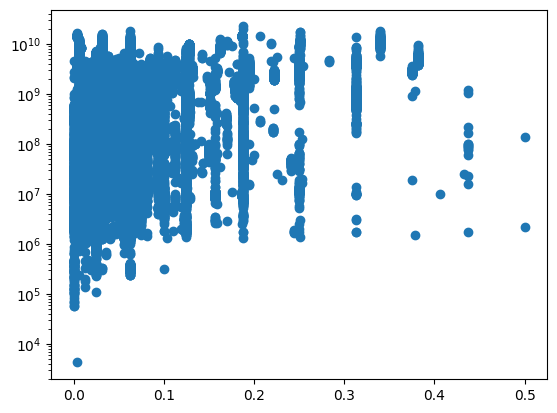

In [ ]:
cpu_req_vs_coresec = joined.map(lambda x: (x[0],x[2])).collect()

for elem in cpu_req_vs_coresec[:10]:
    print(elem)

plt.scatter(*zip(*cpu_req_vs_coresec))
plt.yscale("log")
plt.show()

In [ ]:
cpu_req_vs_core = joined.map(lambda x: (x[0],x[2]/x[1])).collect()

In [55]:
for elem in cpu_req_vs_core[:10]:
    print(elem)

# plt.scatter(*zip(*cpu_req_vs_core), s = [1, ]*len(cpu_req_vs_core))
plt.bar(*zip(*cpu_req_vs_core))
plt.show()

(0.0, 0.06907011764705882)
(0.0, 0.07257211764705883)
(0.0, 0.002753858823529412)
(0.0, 0.0003291164705882353)
(0.0, 0.029615529411764707)
(0.0, 0.11411882352941176)
(0.0, 0.0066846470588235295)
(0.0, 0.005129535294117647)
(0.0, 0.00043219176470588234)
(0.0, 0.03909988235294118)


KeyboardInterrupt: 

This plot shows that, in general, tasks requiring more CPU are using less than the others.

## Appendix

Alternate approach with SparkSQL, allowing the use of DataFrames:
from pyspark.sql import SparkSession

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local(*]") \
    .appName("Cluster analysis") \
    .getOrCreate()

### With DataFrames

It would be nice to have the tabular methods provided by DataFrames. Fortunately, Spark offers a DataFrame API, through their Spark SQL. To [load a CSV as a DataFrame](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrameReader.csv.html#pyspark.sql.DataFrameReader.csv),

In [ ]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType, FloatType, IntegerType, LongType
field_to_spark_type = {
    'time': LongType,
    'machine ID': LongType,
    'event type': IntegerType,
    'platform ID': StringType,
    'CPUs': FloatType,
    'Memory': FloatType
}
machine_events_schema = StructType([
    StructField(field['content'].replace(' ', '_'), field_to_spark_type[field['content']](), field['mandatory']) for field in schemas['machine_events']['fields']
])

machine_events = spark.read \
    .format('csv') \
    .option("header","true") \
    .schema(machine_events_schema) \
    .load("../data/machine_events/part-00000-of-00001.csv")

Let us check that the schema is as we expect

In [ ]:
machine_events.printSchema()

And inspect the first few data

In [ ]:
for elem in machine_events.take(5):
	print(elem.asDict())

How much events do we have?

In [ ]:
machine_events.count(), machine_events.filter(machine_events.event_type == 1).count(),machine_events.filter(machine_events.event_type == 2).count()

In [ ]:
machine_events.filter(machine_events.event_type == 0).CPUs